In [1]:
using Revise, Plots, LinearAlgebra, LaTeXStrings, Random
using FFTW: fft, fftshift

In [2]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
domain = [0, 1]

x0 = [0.4, 0.7]
a0 = [1.5, -1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure{Float64}([0.4, 0.7], [1.5, -1.0], 1, 2)

In [4]:
# Define the number of Fourier coefficients
fc = 6 
n = 2fc + 1

# Define noise level
noise_level = 0.05

# Seed for noise
Random.seed!(12)

TaskLocalRNG()

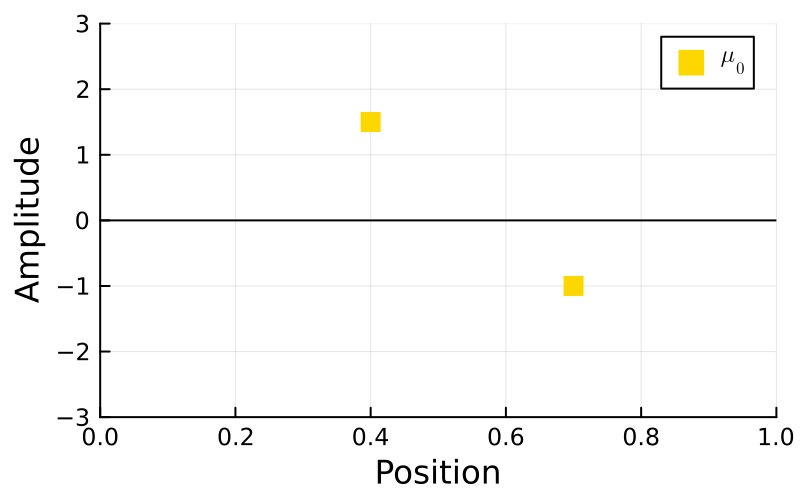

In [5]:
n_coarse_grid = 21
n_plt_grid = 1001

plt_grid = grid(domain, n_plt_grid)

plot_size = (400, 250) .* 1
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=200)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot_spikes!(plt, μ0, color=:gold, label=L"μ_0", marker=:square)

In [6]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]), var"#Φ#13"{var"#ϕ#12"{Float64, Vector{Int64}}}(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, Vector{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, Vector{Int64}}}(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]))), :fourier)

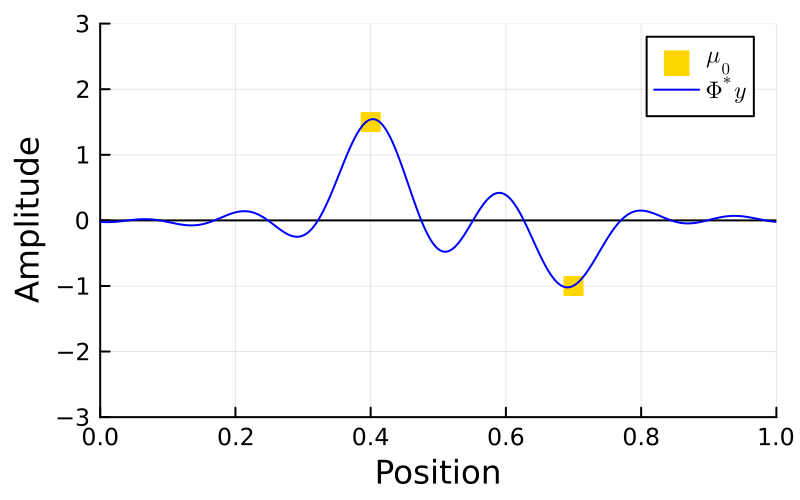

In [7]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(μ0...)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

# plot!(plt_obs, plt_grid, ops.adjΦ(y0), label=L"Φ^{\ast}y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y), label=L"Φ^{\ast}y", color=:blue)

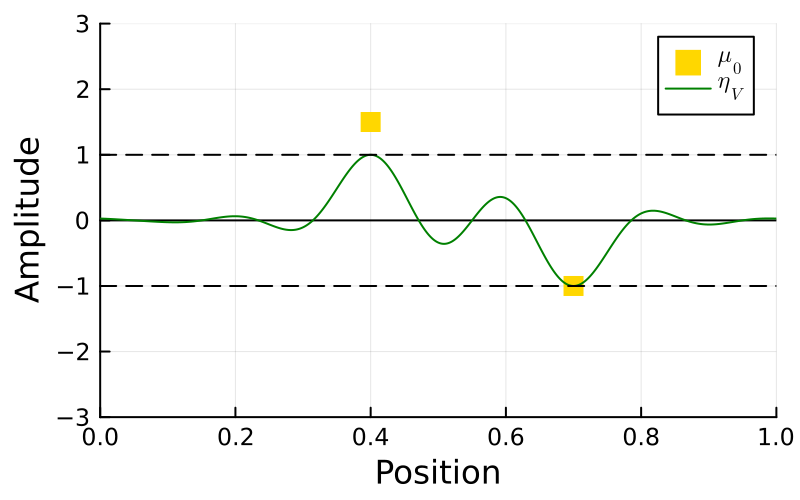

In [8]:
ηV = build_ηV(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV(plt_grid), label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## SDP

In [17]:
coarse_grid = grid(domain, n_coarse_grid)
λ₀(coarse_grid, ops.ϕ, y, 1e-2)

1.5280410639909652

In [18]:
λ = 0.05

prob = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)

prob_sdp = deepcopy(prob)

solve!(prob_sdp, :SDP)

DiscreteMeasure{Float64}([0.39902435076401865, 0.7005329540219596], [1.4638832875801393, -0.9079424886802111], 1, 2)

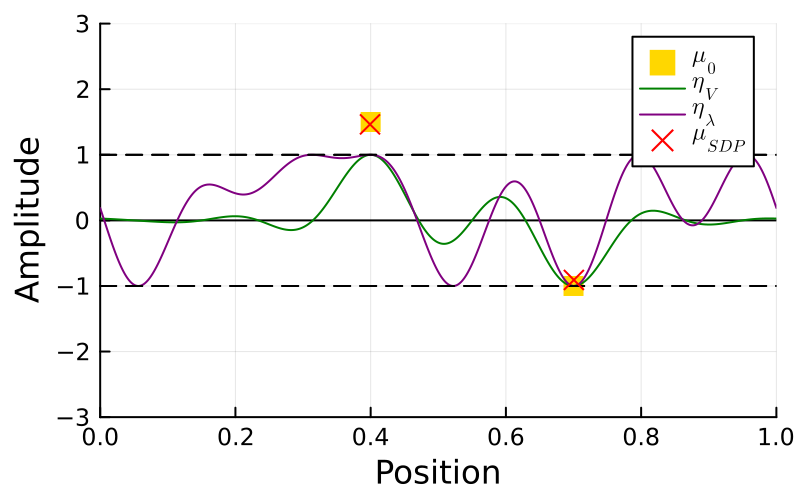

In [19]:
plt_sdp = deepcopy(plt_cert)

# dual polynomial
ηλ = ops.adjΦ(prob_sdp.p, grid=plt_grid) * sqrt(n)
plot!(plt_sdp, plt_grid, ηλ, label=L"η_λ", color=:purple)
hline!(plt_sdp, [1, -1], linestyle=:dash, color=:black, label="")
plot_spikes!(plt_sdp, prob_sdp.μ, color=:red, label=L"μ_{SDP}", marker=:x, markerstrokewidth=2)

## Sliding Frank-Wolfe

In [20]:
prob_sfw = deepcopy(prob)
solve!(prob_sfw, :SFW, options=Dict(:maxits => 5))

BLASSO(ComplexF64[-0.4015517919910227 - 0.021752261701274464im, 0.6950650515740487 - 0.026053451063618067im, -0.42675138789016437 - 0.0004792878687543689im, -0.07093875944503056 + 0.22868708200372168im, 0.32554016972063704 - 0.5728427197504238im, -0.25061727841844 + 0.49086178177560347im, 0.1775543481278613 + 0.0im, -0.25061727841844 - 0.49086178177560347im, 0.32554016972063704 + 0.5728427197504238im, -0.07093875944503056 - 0.22868708200372168im, -0.42675138789016437 + 0.0004792878687543689im, 0.6950650515740487 + 0.026053451063618067im, -0.4015517919910227 + 0.021752261701274464im], Operators(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]), var"#Φ#13"{var"#ϕ#12"{Float64, Vector{Int64}}}(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, Vect

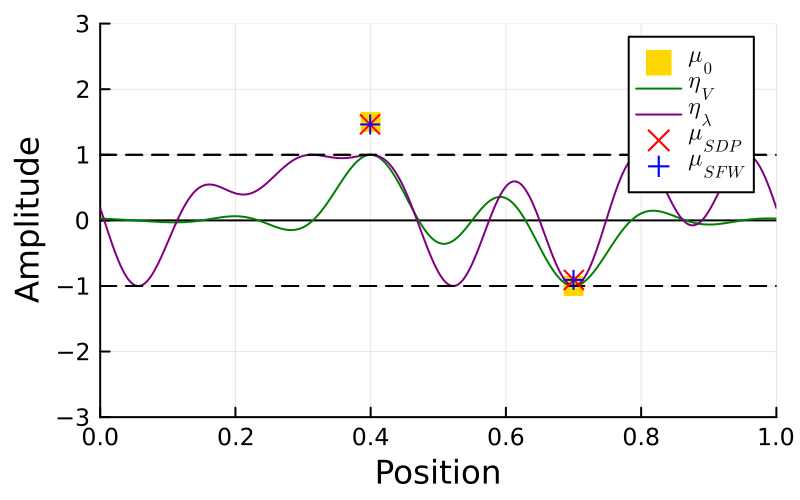

In [21]:
plt_sfw = deepcopy(plt_cert)

plot!(plt_sfw, plt_grid, ηλ, label=L"η_λ", color=:purple)
hline!(plt_sfw, [1, -1], linestyle=:dash, color=:black, label="")
plot_spikes!(plt_sfw, prob_sdp.μ, color=:red, label=L"μ_{SDP}", marker=:x, markerstrokewidth=2)
plot_spikes!(plt_sfw, prob_sfw.μ, color=:blue, label=L"μ_{SFW}", marker=:cross, markerstrokewidth=2)